**IMPORTING LIBRARIES**

In [1]:
import pandas as pd
import numpy as np

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as T
import PIL

from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

**DATA TRANSFORM**

In [2]:
transform = T.Compose(
                [T.ToTensor(),T.Normalize((0.5,),(0.5,))]
                     )

**LOADING CIFAR10 DATASET**

In [3]:
import torchvision.datasets as dset
from torch.utils.data import sampler,DataLoader

class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start = 0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples


NUM_TRAIN = 49000
NUM_VAL = 1000

trainSet = dset.CIFAR10(root = 'OneDrive/Documents/Machine Learning/DL/', 
                             train=True, 
                             download=True,
                             transform=transform)

trainLoader = DataLoader(trainSet, 
                          batch_size=128, 
                          sampler=ChunkSampler(NUM_TRAIN, 0))

valSet = dset.CIFAR10(root = 'OneDrive/Documents/Machine Learning/DL/', 
                           train=True, 
                           download=True,
                           transform=transform)

valLoader = DataLoader(valSet, 
                        batch_size=128, 
                        sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))

testSet = dset.CIFAR10(root = 'OneDrive/Documents/Machine Learning/DL/', 
                            train=False, 
                            download=True,
                            transform=transform)

testLoader = DataLoader(testSet, 
                         batch_size=128)
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


**VISUALIZING DATA**

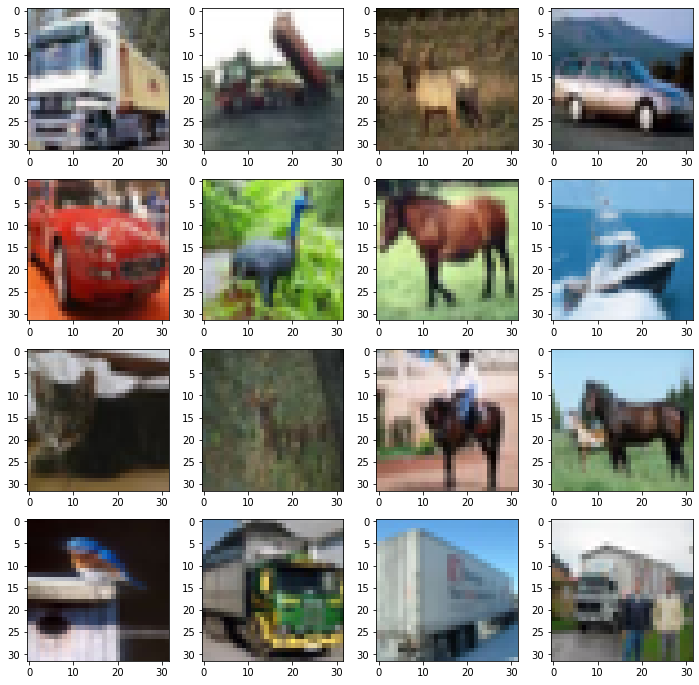

In [4]:
fig = plt.figure(figsize = (12,12))
for i in range(1,17):
    plt.subplot(4,4,i)
    plt.imshow(trainSet.data[i])

In [5]:
print(trainSet.data.shape)
print(testSet.data.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


**TRAINING and ACCURACY FUNCTIONS**

In [6]:
def train(net,loss_func,opt,num_epoch=1):
    iteration = 0
    loss_list = []
    iter_list = []
    val_acc_list = []
    for epoch in range(num_epoch):
        print("Epoch %d/%d"%(epoch+1,num_epoch))
        net.train()
        for i,data in enumerate(trainLoader,0):
            torch.cuda.empty_cache()
            inputs, labels = data

            # Using GPU
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Wrapping in Variable
            inputs, labels = Variable(inputs), Variable(labels)

            # Clearing previous gradients
            opt.zero_grad()

            # Forward Propagation
            scores = net(inputs)
            loss = loss_func(scores,labels)

            # Backpropagation
            loss.backward()
            opt.step()

            iteration += 1
            if iteration % 50 == 0:
                loss_list.append(loss)
                iter_list.append(iteration)
                # Print Loss
                print('Iteration: %d, loss = %0.2f'%(iteration,loss))
        
        val_acc = check_accuracy(net,valLoader)
        val_acc_list.append(val_acc)
        
    
    return iter_list,loss_list,val_acc_list

In [7]:
def vizualize(iter_l,loss_l,val_l,epochs=1):
    # visualizing loss function
    plt.plot(iter_l,loss_l)
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Optimizing Lost function over CIFAR10 Dataset')
    plt.show()

    #visualizing Val Accuracy
    plt.plot(np.arange(epochs),val_l)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Validation Set')
    plt.show()

In [8]:
def check_accuracy(model,loader):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')
    num_correct = 0
    num_samples = 0
    model.eval()
    for i,data in enumerate(loader,0):
            torch.cuda.empty_cache()
            inputs, labels = data
            
            # Using GPU
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forward Propagation
            scores = model(inputs)
            # Get predictions from the maximum value
            predicted = torch.max(scores.data, 1)[1]
                
            # Total number of labels
            num_samples += len(labels)
                
            num_correct += (predicted == labels).sum()
            
    accuracy = 100 * num_correct / float(num_samples)
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, accuracy))
    return accuracy

**CNN MODEL FOR CIFAR10**

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        
        # Defining CNN
        # Conv Architecture:
        '''
        conv2d->ReLU->conv2d->ReLU->BatchNorm->maxpool2d(32x32=>16x16)->
        conv2d->ReLU->conv2d->ReLU->BatchNorm->maxpool2d(16x16=>8x8)->Dropout->
        conv2d->ReLU->conv2d->ReLU->BatchNorm->maxpool2d(8x8=>4X4)->
        Classifier
        '''
        self.cnn = nn.Sequential(nn.Conv2d(3,32,3,1,1),
                                 nn.ReLU(inplace = True),
                                 nn.BatchNorm2d(32),
                                 nn.Conv2d(32,64,3,1,1),
                                 nn.ReLU(inplace = True),
                                 nn.BatchNorm2d(64),
                                 nn.MaxPool2d(2,2),
                                 
                                 nn.Conv2d(64,128,3,1,1),
                                 nn.ReLU(inplace = True),
                                 nn.BatchNorm2d(128),
                                 nn.Conv2d(128,256,3,1,1),
                                 nn.ReLU(inplace = True),
                                 nn.BatchNorm2d(256),
                                 nn.MaxPool2d(2,2),
                                 nn.Dropout2d(p=0.3),
                                 
                                 nn.Conv2d(256,512,3,1,1),
                                 nn.ReLU(inplace = True),
                                 nn.BatchNorm2d(512),
                                 nn.Conv2d(512,512,3,1,1),
                                 nn.ReLU(inplace = True),
                                 nn.BatchNorm2d(512),
                                 nn.MaxPool2d(2,2)
                                )
        
        # Defining Classifier
        # Classifier Architecture:
        '''
        CNN->Flatten->
        Linear->ReLU->
        Linear->ReLU->Dropout->
        Linear->ReLU->
        Linear-> Scores
        '''
        self.classifier = nn.Sequential(nn.Linear(8192,2048),
                                        nn.ReLU(inplace=True),
                                        
                                        nn.Linear(2048,1024),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(p=0.3),
                                        
                                        nn.Linear(1024,512),
                                        nn.ReLU(inplace=True),
                                        
                                        nn.Linear(512,10)
                                       )
        
    def forward(self,x):
        
        # Forward Propagation 
        x = self.cnn(x)
        x = x.reshape(-1,4*4*512)
        x = self.classifier(x)
        
        return x
    

**GPU!**

In [10]:
print("GPU Available:",torch.cuda.is_available())
print("Number of GPU available:",torch.cuda.device_count())

GPU Available: True
Number of GPU available: 1


In [11]:
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    print("Running on the CPU")

Running on the GPU


**DEFINING NET, LOSS AND OPTIMIZER**

In [12]:
net = CNN()
net.to(device)
loss_func = nn.CrossEntropyLoss()
opt = optim.Adam(params = net.parameters(), lr=1e-3)

**TRAINING and VIZUALISATION of MODEL**

In [13]:
num_epoch = 1
a,b,c = train(net,loss_func,opt,num_epoch)

Epoch 1/1
Iteration: 50, loss = 1.58
Iteration: 100, loss = 1.74
Iteration: 150, loss = 1.40
Iteration: 200, loss = 1.17
Iteration: 250, loss = 1.27
Iteration: 300, loss = 1.24
Iteration: 350, loss = 1.06
Checking accuracy on validation set
Got 632 / 1000 correct (63.20)


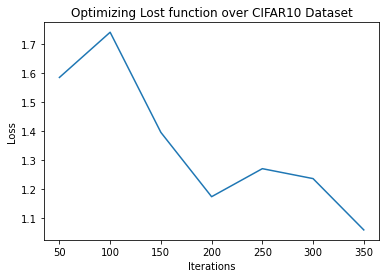

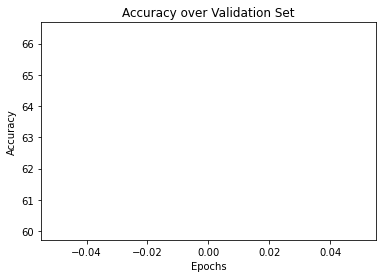

In [14]:
vizualize(a,b,c,num_epoch)

In [15]:
_ = check_accuracy(net,testLoader)

Checking accuracy on test set
Got 6282 / 10000 correct (62.82)


In [ ]:
check_accuracy(net,trainLoader)

In [ ]:
check_accuracy(net,testLoader)

In [ ]:
check_accuracy(net,valLoader)

**SAVING MODEL**

In [ ]:
torch.save(net.state_dict(), 'cnn_cifar10')

**LOADING MODEL**

In [ ]:
model = CNN()
model.load_state_dict(torch.load('cnn_cifar10'))
model.to(device)
model.eval()